In [29]:
%load_ext autoreload
%autoreload 2
import statsmodels.api as sm
from plotly.subplots import make_subplots
from helpers import *

data_folder = 'DATA/'
plot_folder = 'plots/'

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# load data
movie_data = pd.read_pickle(data_folder + "movie_data_final.pickle")
characters_data = pd.read_pickle(data_folder+'final.pickle')

In [31]:
#adding the decade for analyses (this should be moved in the data construction)
characters_data['decade'] = ((characters_data['release_date'].astype(int))//10)*10

# Analysis per Genre
After having done all the previous analyses, we wondered whether the trends observed were present in all movies. Our hypothesis is that some movies genre would have a depiction more stereotypical than others. This was already explored superficially during our clustering analysis. We here selected 6 genres: Action, Adventure, Western, Musical, Drama and Horror. These genres came up as being more stereotypical (Action, Adventure and Western) or less stereotypical (Musical, Drama and Horror) in our clustering analysis. We will therefore perform a deep analysis to analyse the representation of women in these movies

In [32]:
# define genres to analyse
genres = ['Action', 'Adventure', 'Western', 'Musical', 'Drama', 'Horror']
# merge movie genres with characters data to anaylse per genre
characters_with_genre = pd.merge(characters_data, movie_data[['IMDB_ID','genre']], how='left', on='IMDB_ID')
characters_with_genre

,character_ID,wikipedia_ID,freebase_ID,actor_ethnicity,actor_name,personnas,IMDB_ID,character_name,actor_gender,box_office_revenue,name,release_date,actor_age,Verbs,Adjectives,Nouns,Chunks,decade,genre
0,1,975900.0,/m/03vyhn,NaN,wanda de jesus,NaN,tt0228333,Akooshay,F,NaN,Ghosts of Mars,2001.0,42.0,"[discovered, created, wiped]","[second, 22nd, ancient, fierce]","[Set, century, film, miners, Martian, miners, ...","[[(Set, NNP)], (second, JJ), (22nd, JJ), (cent...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
1,2,975900.0,/m/03vyhn,/m/044038p,natasha henstridge,NaN,tt0228333,Lieutenant Melanie Ballard,F,14010832.0,Ghosts of Mars,2001.0,27.0,"[terraformed, allowing, become, authority, sen...","[matriarchal, police, second, second, small, s...","[film, depicts, Mars, positions, story, concer...","[(film, NN), (depicts, NNS), (Mars, NNP), (84,...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
2,3,975900.0,/m/03vyhn,/m/0x67,ice cube,NaN,tt0228333,Desolation Williams,M,14010832.0,Ghosts of Mars,2001.0,32.0,"[wearing, become, named, named, held, mining, ...","[transport, remote, ancient, horrific, team, d...","[pressure, suits, society, prisoner, Williams,...","[(wearing, VBG), (pressure, NN), (suits, NNS),...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
3,4,975900.0,/m/03vyhn,NaN,jason statham,NaN,tt0228333,Sgt Jericho Butler,M,14010832.0,Ghosts of Mars,2001.0,34.0,"[walk, wearing, sent, opened, released, posses...","[second, pick, disembodied, possible, Unfortun...","[half, humans, surface, pressure, suits, team,...","[(second, JJ), (half, NN), (22nd, CD), (humans...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
4,5,975900.0,/m/03vyhn,NaN,clea duvall,NaN,tt0228333,Bashira Kincaid,F,NaN,Ghosts of Mars,2001.0,23.0,"[killed, returning, blame, cot, escapes, leaving]",[massacre],"[pick, transport, prisoner, Desolation, Willia...","[(pick, NN), (transport, NN), (prisoner, NN), ...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336453,336454,NaN,NaN,NaN,caleb silvers,NaN,tt9914522,Evan,M,NaN,The Holden Family Plan,2019.0,24.0,"[make, regarding]",[new],"[Mackenzie, husband, decision]","[[(Mackenzie, NNP)], (new, JJ), (husband, NN),...",2010,[Drama]
336454,336455,NaN,NaN,NaN,bethany hazelitt,NaN,tt9914522,Mackenzie,F,NaN,The Holden Family Plan,2019.0,29.0,"[murdered, regarding, make, regarding]","[new, niece]","[Holden, sister, brother, law, husband, Evan, ...","[[(Holden, NNP)], (sister, NN), (brother, NN),...",2010,[Drama]
336455,336456,NaN,NaN,NaN,joshua bootz,NaN,tt9914522,Evan's dad,M,NaN,The Holden Family Plan,2019.0,NaN,"[make, regarding, regarding]",[new],"[Mackenzie, husband, decision, make, niece]","[[(Mackenzie, NNP)], (new, JJ), (husband, NN),...",2010,[Drama]
336456,336457,NaN,NaN,NaN,vince camaj,NaN,tt9914522,Todd,M,NaN,The Holden Family Plan,2019.0,NaN,NaN,NaN,NaN,NaN,2010,[Drama]


## 1. Gender Proportions
First, let's see how the proportion of male and female actors evolve through time for our selected genres.

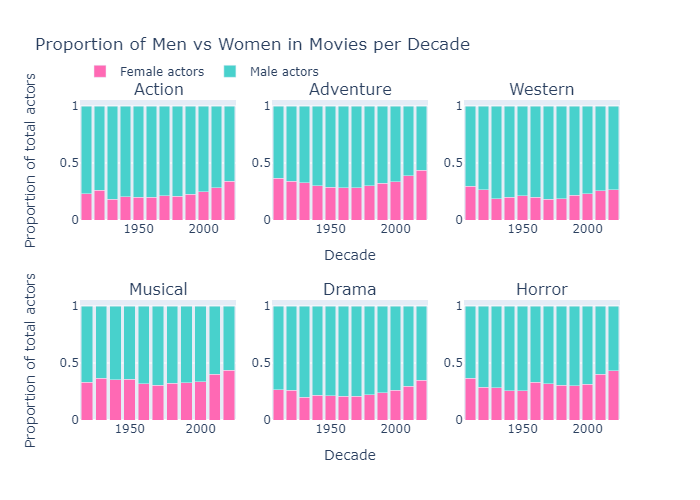

In [33]:
# Create a 2x3 grid of subplots
subplot = make_subplots(rows=2, cols=3, subplot_titles=genres)

for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    subplot_proportion_men_women_per_decade(data, idx=i, subplot=subplot)

# Update layout for the entire subplot
subplot.update_layout(
    height=500,
    width=700,
    title_text='Proportion of Men vs Women in Movies per Decade',
    xaxis2=dict(title='Decade'),
    xaxis5=dict(title='Decade'),
    yaxis=dict(title='Proportion of total actors'),
    yaxis4=dict(title='Proportion of total actors'),
    barmode='stack',
    legend=dict(x=0, y=1.135, traceorder='normal', orientation='h')
)
subplot.write_html(plot_folder+'gender_proportion_per_genre_per_decade_small.html', auto_open=True)
subplot.show('png')

For all genres we see more or less a similar pattern that what was seen taking all the movies together, i.e. the proportion of women in movies increases from the 60s-70s up till now. However, we do see that some genres seems to have lower proportion of women throughout the decades, mainly: Action, Western and Drama.
To determine better study the increase of the last 50 years, we will fit a regression line on the proportion of female. This will help us study the difference of increase in the last decades and estimate when each gender will reach parity.

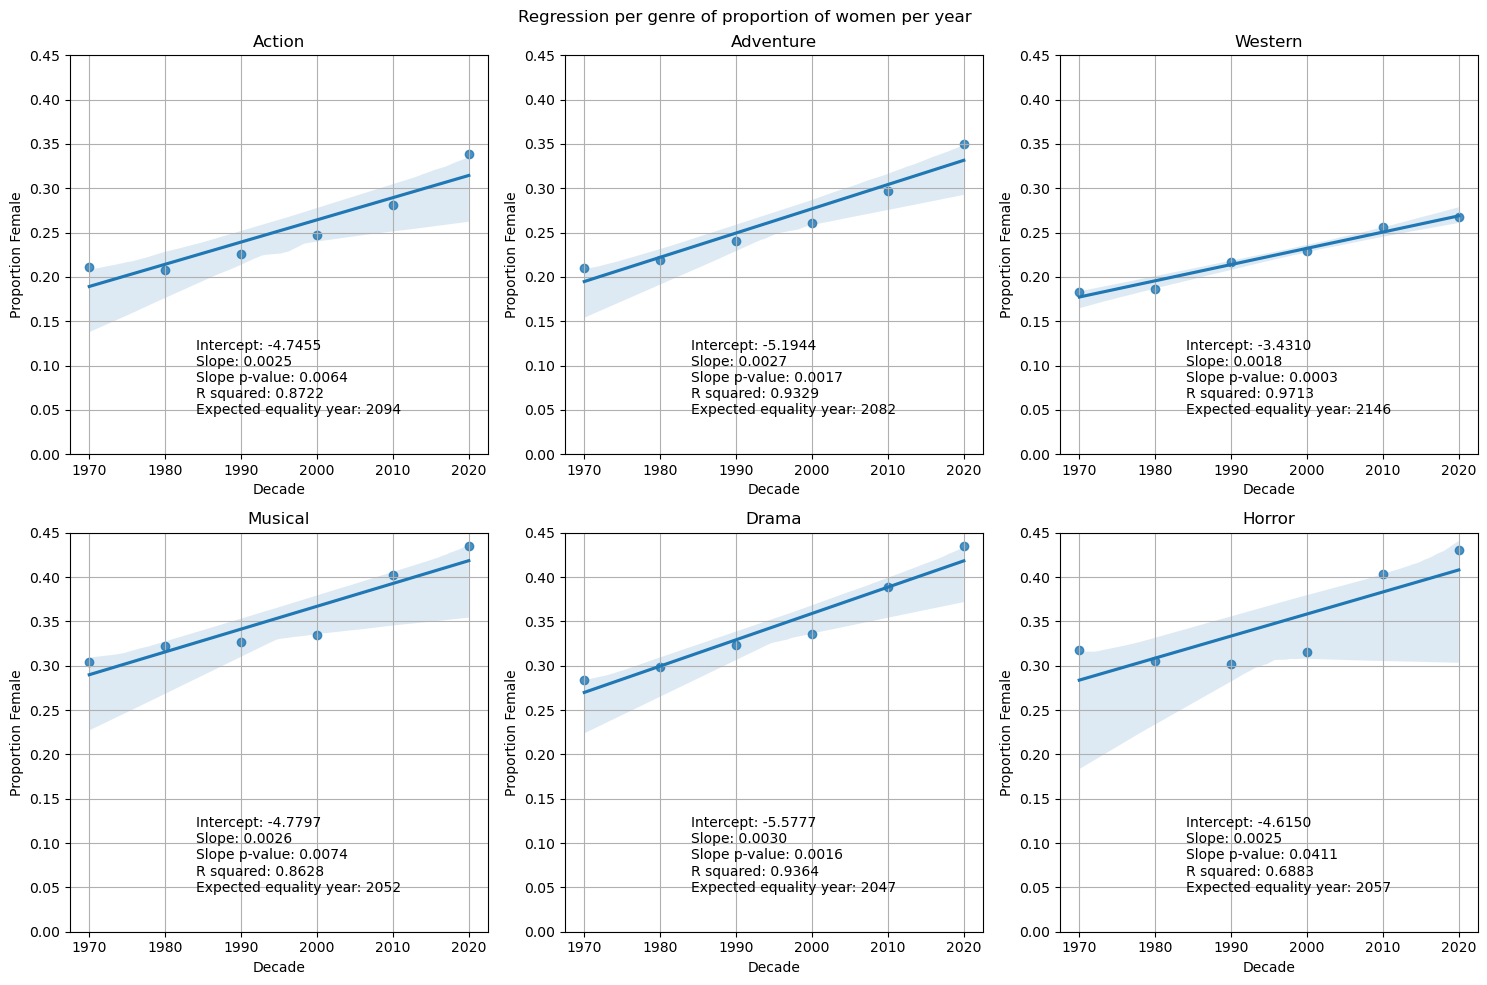

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    final_characters_grouped_by_decade = data.groupby(data['decade'])

    proportion_female = final_characters_grouped_by_decade['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

    proportions_female_per_decade = pd.DataFrame()
    proportions_female_per_decade['decade'] = proportion_female.index
    proportions_female_per_decade['proportion'] = proportion_female.values

    proportion_female_after1970 = proportions_female_per_decade[proportions_female_per_decade['decade'] >= 1970]

    # Fit the linear model using statsmodels
    X = sm.add_constant(proportion_female_after1970['decade'])
    y = proportion_female_after1970['proportion']
    model = sm.OLS(y, X).fit()

    # Plot the data and the linear regression line
    sns.regplot(x='decade', y='proportion', data=proportion_female_after1970, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(genre)
    axes[i // 3, i % 3].set_xlabel('Decade')
    axes[i // 3, i % 3].set_ylabel('Proportion Female')
    axes[i // 3, i % 3].set_ylim([0,0.45])
    axes[i // 3, i % 3].grid()

    # Annotate with intercept and slope values
    intercept, slope = model.params
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    fifty_fifty = (0.5-intercept)/slope
    axes[i // 3, i % 3].annotate(f'Intercept: {intercept:.4f}\nSlope: {slope:.4f}\nSlope p-value: {p_value:.4f}\nR squared: {r_squared:.4f}\nExpected equality year: {fifty_fifty:.0f}', xy=(0.3, 0.1), xycoords='axes fraction', fontsize=10)

fig.suptitle('Regression per genre of proportion of women per year')
plt.tight_layout()
plt.show()

First of all, the plot above shows that the R squared of almost all regression is above 0.85. This means that a linear regression explains the variance of the data fairly well. We can thus conclude that the proportion of women in Action, Adventure, Western, Musical and Drama movies has been linearly increasing since the 70s. For the horror movies, we see that the R squared coefficient is only of 0.6883. When looking at the plot, it seems that there is indeed an increase in the proportion of women but that it starts more in 2000 than in 1970.

The slopes can be considered as how fast is the ratio evolving. The genre that has the slowest evolution is Western with a slope of 0.018. Drama movies have the steepest slope and thus the fastest increase with a slope of 0.003. Interestingly, the other genre studied all have a slope of 0.0025-0.0027. This means that even though Action and Adventure movies are considered to have a more stereotypical depiction of women, their gender ratio is evolving similarly as Musical and Horror movies. They however had a lower proportion of women in the 70s and thus still have a lower proportion of women nowadays.

When using the regression equation to predict the year in which each movie genre reaches equality, unsurprisingly the genre with the steepest slope, Drama, is expected to reach equality the quickest, i.e. by 2047. Musical and Horror movies are also predicted to reach in ~30 years.
Similarly, the genre with the smallest slope, Western, is expected to reach parity the latest, i.e. by 2146. Action and Adventure movies are expected to have equal representation of genders in ~60 and ~50 years respectively.

To sum up, we see that Action, Adventure and Musical movies show an increase in women representation since the 1970s at a similar rate, even though they were initially classified in different stereotypical clusters. Horror movies seems to have started this increase in representation a few decades later but still show an increase rate similar to the other genres. Western movies however, seem to progress much more slowly than others.

To gain a deeper understanding of women's representation in movie, we will plot the proportion of movies per year that have 0-25% actresses, 25-50%, 50-75% or 75-100% actresses and see if these proportion differ depending on the genre of the movie.

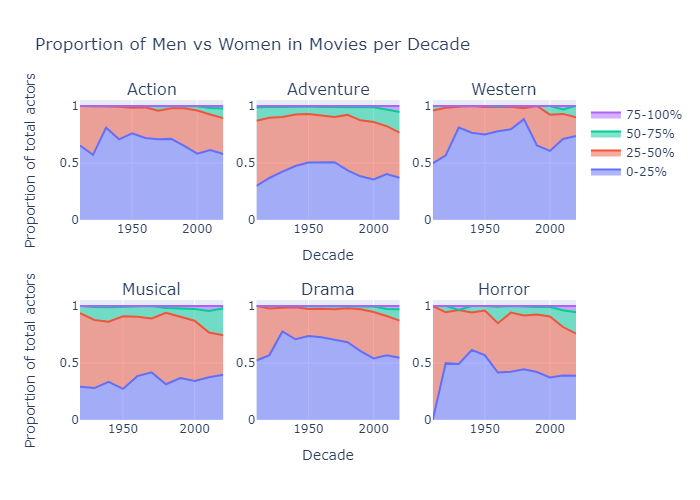

In [35]:
subplot = make_subplots(rows=2, cols=3, subplot_titles=genres)

for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    subplot_proportion_movies_different_percentages_women(data, idx=i, subplot=subplot)

subplot.update_layout(
    height=500,
    width=700,
    title='Proportion of Men vs Women in Movies per Decade',
    xaxis2=dict(title='Decade'),
    xaxis5=dict(title='Decade'),
    yaxis=dict(title='Proportion of total actors'),
    yaxis4=dict(title='Proportion of total actors'),
    barmode='stack'
)
subplot.write_html(plot_folder+"movie_proportions_percentages_actress_by_genre.html", auto_open=True)
subplot.show('png')

We see that Action, Western and Drama movies have consistently throughout times more than 50% of movies that have less than 25% of women in them. It is surprising to observe this for Drama movies that was actually the genre in which the average proportion of women increased the quickest since the 70s. This plot however highlights that this average proportion was probably driven by a few movies with very high women proportion, while most of the movies remain with a poor representation.

## 2. Average Age per Gender
Now, we will analyse how the mean age of women and men evolves through time for our selected genres

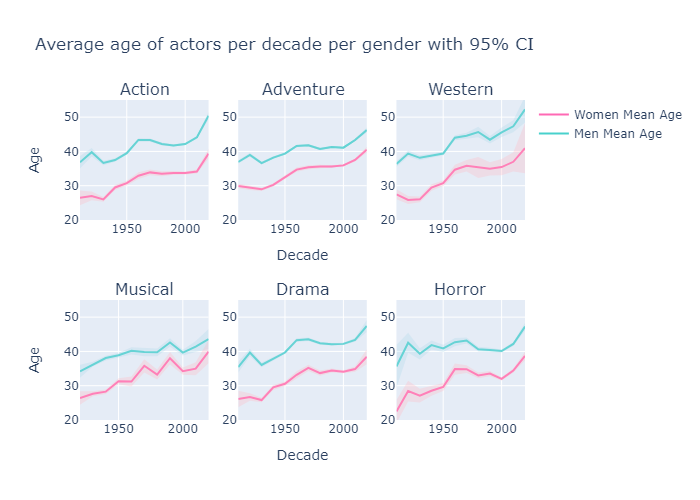

In [36]:
subplot = make_subplots(rows=2, cols=3, subplot_titles=genres)
for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    subplot_average_age_actor_across_decades(data, idx=i, subplot=subplot)

# Create figure
subplot.update_layout(
    height=500,
    width=700,
    xaxis2=dict(title='Decade'),
    xaxis5=dict(title='Decade'),
    yaxis=dict(title='Age'),
    yaxis4=dict(title='Age'),
    title='Average age of actors per decade per gender with 95% CI',
    hovermode="x"
)
subplot.write_html(plot_folder+"age_through_decade_per_genre.html", auto_open=True)
subplot.show('png')

In the plots above, we see that actor mean ages are increasing throughout the decades and that actresses are generally younger but do follow a similar increase in age than actors. The age gap between women and men does not seem to be diminishing through time Overall, there are no genre in which the ages of men and women actors are similar, except for the last decade in Musical movies. Women are thus depicted as younger than men in most movies genres and this stereotypes prevails throughout the decades.

## 3. Main Characters Gender Ratio
After looking at women proportions and ages, we want to analyse how women are portrayed. Maybe some movie genre have a high proportion of female character but they are all secondary roles. To study this, we plotted the female to male ratio of main characters per movie genre throughout the year.

In [37]:
# remove nans and transform as list
movies_main_char = movie_data.copy().dropna(subset=['main character genders'])
movies_main_char['main character genders'] = movies_main_char['main character genders'].apply(ast.literal_eval)

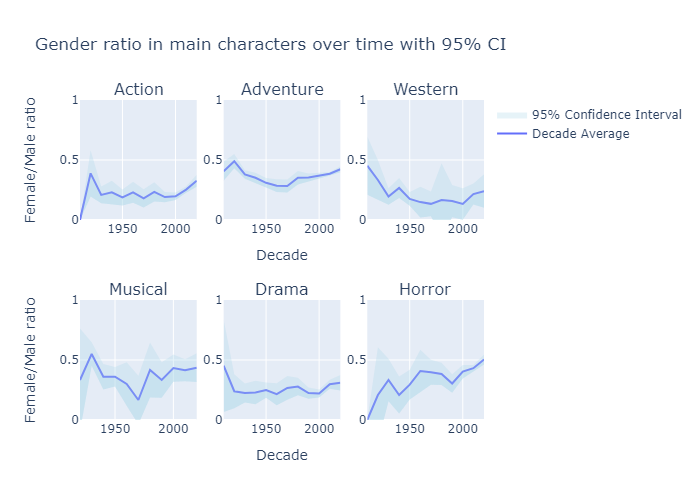

In [39]:
subplot = make_subplots(rows=2, cols=3, subplot_titles=genres)
for i, genre in enumerate(genres):
    data = subset_df(movies_main_char, genre)
    subplot_gender_ratio(data, idx=i, subplot=subplot)

subplot.update_layout(
    height=500,
    width=700,
    xaxis2=dict(title='Decade'),
    xaxis5=dict(title='Decade'),
    yaxis=dict(title='Female/Male ratio'),
    yaxis4=dict(title='Female/Male ratio'),
    title='Gender ratio in main characters over time with 95% CI',
    hovermode="x")

subplot.write_html(plot_folder+"proportion_main_characters_per_genre.html", auto_open=True)
subplot.show('png')

On most plots the confidence intervals are quite big, it is thus hard to say if and how the female/male main characters ratio evolved through time.
Adventure movies is the only genre that has a 95% CI small enough to be able to retrieve information from the plot. However, for this genre the ratio seems to not be evolving too much, staying between 0.3 and 0.4.

Sadly we cannot conclude much more from this analysis because of the low amount of data we were able to generate about main characters